# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

### Import useful libraries

In [5]:
!pip install datasets

In [6]:
# Standard libraries
import os
import re
import string
import copy
import json
import random
import zipfile
import requests
import urllib.request
from pathlib import Path
from collections import Counter

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display, HTML
from wordcloud import WordCloud

# Text processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')

# Machine learning metrics
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
    precision_recall_curve,
    classification_report,
    auc
)
from sklearn.metrics import PrecisionRecallDisplay

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Hugging Face Transformers
from transformers import (
    AutoModelForSequenceClassification,
    TFAutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    DataCollatorWithPadding,
    Trainer
)
from scipy.special import softmax

# Datasets
from datasets import Dataset

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Create train, validation and test DataFrames
 * Download json files *test.json*, *training.json* and *validation.json* from [here](https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/).
 * Load the json files into pandas DataFrames

In [7]:
base_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/refs/heads/main/2024-2025/Assignment%201/data/"
json_files = ["test.json", "training.json", "validation.json"]
local_dir = Path("Assignment%201/data")
local_dir.mkdir(parents=True, exist_ok=True)

# Download each file
for file_name in json_files:
    url = base_url + file_name
    response = requests.get(url)
    if response.status_code == 200:
        with open(local_dir / file_name, "wb") as file:
            file.write(response.content)
        print(f"Downloaded {file_name}")
    else:
        print(f"Failed to download {file_name}")

# Load JSON files into pandas DataFrames
dataframes = {}
for file_name in json_files:
    with open(local_dir / file_name, "r") as file:
        data = json.load(file)
        dataframes[file_name] = pd.DataFrame(data)


# Load the original datasets from the specified JSON files into separate DataFrames
original_train_df = dataframes['training.json']
original_validation_df = dataframes['validation.json']
original_test_df = dataframes['test.json']

Downloaded test.json
Downloaded training.json
Downloaded validation.json


### Transform the DataFrames as requested

In [8]:
def determine_majority(response_list):
    """
    Counts the occurrences of "YES" and "NO" in the input list and returns:
      - 1 if "YES" is the majority,
      - 0 if "NO" is the majority,
      - 2 if there is a tie.
    """
    yes_count = response_list.count("YES")
    no_count = response_list.count("NO")
    if yes_count > no_count:
        return 1
    elif no_count > yes_count:
        return 0
    else:
        return 2


def transform_df(df):
    """
    - Transposes the DataFrame.
    - Adds a column `hard_label_task1` based on the majority label in `labels_task1`.
    - Filters rows where `lang` is 'en' and excludes rows where `hard_label_task1` equals 2(tie).
    - Selects specific columns for the final output.
    """
    df = df.T
    df['hard_label_task1'] = df['labels_task1'].apply(determine_majority)
    df = df[df['lang'] == 'en']
    df = df[df['hard_label_task1'] != 2]
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]
    return df


In [9]:
# Apply the `transform_df` function to preprocess the training, validation, and test DataFrames
original_train_df = transform_df(original_train_df)
original_validation_df = transform_df(original_validation_df)
original_test_df = transform_df(original_test_df)

original_train_df

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0
...,...,...,...,...
203256,203256,en,idk why y’all bitches think having half your a...,1
203257,203257,en,This has been a part of an experiment with @Wo...,1
203258,203258,en,"""Take me already"" ""Not yet. You gotta be ready...",1
203259,203259,en,@clintneedcoffee why do you look like a whore?...,1


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [10]:
# Create copies of the original datasets to avoid modifying them directly
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

### Perform Data Cleaning
 * Remove emojis
 * Remove hashtags
 * Remove mentions
 * Remove URLs
 * Remove special characters and symbols
 * Remove specific quote characters
 * Convert to lowercase
 * Tokenize the tweet
 * Remove stopwords
 * Lemmatize the word


In [11]:
# Initialize the WordNet lemmatizer for reducing words to their base form
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):
    """
    Cleans a tweet by removing unwanted characters, URLs, hashtags, mentions, and stopwords,
    and by performing lemmatization.
    """
    # Remove non-ASCII characters
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove non-alphanumeric characters (except spaces)
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Remove specific quote characters
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    # Convert to lowercase
    tweet = tweet.lower()
    # Tokenize the text
    words = word_tokenize(tweet)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # Apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join the cleaned words back into a single string
    cleaned_tweet = ' '.join(words)

    return cleaned_tweet

# Apply the `clean_tweet` function to the tweet column in the training, validation, and test datasets
train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)


In [12]:
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,writing uni essay local pub coffee random old ...,1
200003,200003,en,2021 1921 dont appreciate two ride team member...,1
200006,200006,en,according customer plenty time go spent stirli...,1
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1
200008,200008,en,new shelf week looking forward reading book,0


# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

### Download and extract GloVe embeddings with dimension of 100.

In [66]:
def download_glove_embeddings(glove_url, save_path='glove.zip', extract_path='glove'):
    """
    Downloads and extracts GloVe embeddings if not already present.
    """
    # Check if the embeddings are already extracted
    if not os.path.exists(extract_path):
        print("Downloading GloVe embeddings...")

        # Stream download with progress bar
        response = requests.get(glove_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))

        with open(save_path, 'wb') as f, tqdm(
            desc="Downloading",
            total=total_size,
            unit='B',
            unit_scale=True,
            unit_divisor=1024,
        ) as bar:
            # Write the content in chunks and update the progress bar
            for data in response.iter_content(chunk_size=1024):
                f.write(data)
                bar.update(len(data))

        print("Extracting GloVe embeddings...")
        # Extract the zip file to the specified directory
        with zipfile.ZipFile(save_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)

        # Clean up by removing the downloaded zip file
        os.remove(save_path)
        print("Download and extraction complete.")
    else:
        print("GloVe embeddings already downloaded.")


def load_glove_embeddings(filepath, embedding_dim=100):
    """
    Loads GloVe embeddings into a dictionary.
    """
    embeddings = {}
    print(f"Loading GloVe embeddings from {filepath}...")
    with open(filepath, 'r', encoding="utf-8") as f:
        for line in f:
            # Split the line into word and its embedding vector
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    print("GloVe embeddings loaded.")
    return embeddings


# URL for the GloVe embeddings file
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
# Path to save and extract the GloVe embeddings
download_path = 'glove.6B.zip'
extract_path = 'glove'

# Download and extract GloVe embeddings
download_glove_embeddings(glove_url, download_path, extract_path)

# Define the embedding dimension
embedding_dim = 100
# Path to the specific GloVe file for the desired dimension
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')

# Load the embeddings into memory
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)


GloVe embeddings already downloaded.
Loading GloVe embeddings from glove/glove.6B.100d.txt...
GloVe embeddings loaded.
Loaded GloVe embeddings with dimension: 100


### Pad the tweets to have them of the same lenght.

In [67]:
def find_series_max_len(series_list):
    """
    Finds the maximum number of words in any entry across multiple pandas Series.
    """
    # Concatenate all Series into a single Series
    all_text = pd.concat(series_list, ignore_index=True)
    # Calculate the word count for each entry
    word_count = all_text.apply(lambda x: len(str(x).split()))
    max_word_count = word_count.max()
    return max_word_count


def pad_text_column(df, column_name, max_len, pad_token="<PAD>"):
    """
    Pads or truncates text in a specified column to a uniform length.
    """
    # Tokenize the text if not already tokenized
    df['padded_' + column_name] = df[column_name].apply(
        lambda x: x if isinstance(x, list) else str(x).split()
    )
    # Pad or truncate each text entry to the specified length
    df['padded_' + column_name] = df['padded_' + column_name].apply(
        lambda x: x[:max_len] + [pad_token] * (max_len - len(x)) if len(x) < max_len else x[:max_len]
    )
    return df


# Find the maximum length of tweets across train, validation, and test datasets
MAX_LEN = find_series_max_len([train_df['tweet'], validation_df['tweet'], test_df['tweet']])
print(f"Maximum length found: {MAX_LEN}")

# Pad the 'tweet' column in train, validation, and test DataFrames
train_df = pad_text_column(train_df, 'tweet', MAX_LEN)
validation_df = pad_text_column(validation_df, 'tweet', MAX_LEN)
test_df = pad_text_column(test_df, 'tweet', MAX_LEN)

# Print the first padded tweet from the training DataFrame
print(train_df['padded_tweet'].iloc[0])


Maximum length found: 36
['writing', 'uni', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'asking', 'drunk', 'question', 'im', 'trying', 'concentrate', 'amp', 'end', 'good', 'luck', 'youll', 'end', 'getting', 'married', 'use', 'anyway', 'alive', 'well', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


### Build the vocabulary and the embeddings on the train set.

In [68]:
# Tokenize tweets and build vocabulary
def build_vocab_and_embeddings(data, embeddings_index, embedding_dim):
    vocab = {}
    word_embeddings = []
    for tweet in data['padded_tweet']:
        for token in tweet:
            if token not in vocab:
                # Check if the token has a pre-trained embedding, otherwise default to random
                embedding = embeddings_index.get(token, np.random.uniform(-0.1, 0.1, embedding_dim))
                vocab[token] = len(vocab)
                word_embeddings.append(embedding)
    return vocab, word_embeddings

# Build vocabulary and embeddings for the training set
vocab, word_embeddings = build_vocab_and_embeddings(train_df, glove_embeddings, embedding_dim)

### Set the embedding for the Unknown words.

In [69]:
# Special handling for the '[UNK]' token (unknown token)
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)

# Compute the embedding for the unknown token as the mean of all word embeddings
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

### Embed train, validation and test sets.

In [70]:
def embed_tweet(df, vocab, word_embeddings):
    """
    Converts tokens in a tweet dataframe to their corresponding word embeddings.
    Out-of-vocabulary (OOV) tokens are replaced with the embedding of '[UNK]'.
    """
    data = df.copy()
    new_tweet = []
    for tweet in data['padded_tweet']:
        embedded_tweet = []
        for token in tweet:
            if token not in vocab:
                # token is OOV so considered UNK
                embedded_tweet.append(word_embeddings[vocab['[UNK]']])
            else:
                embedded_tweet.append(word_embeddings[vocab[token]])
        new_tweet.append(embedded_tweet)
    data['padded_tweet'] = new_tweet
    return data

# Embed all the df with our extended GloVe embeddings
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)

train_df_embedded.head()

,id_EXIST,lang,tweet,hard_label_task1,padded_tweet
200002,200002,en,writing uni essay local pub coffee random old ...,1,"[[0.17459000647068024, 0.2806999981403351, -0...."
200003,200003,en,2021 1921 dont appreciate two ride team member...,1,"[[0.4375700056552887, 0.5958300232887268, 0.52..."
200006,200006,en,according customer plenty time go spent stirli...,1,"[[-0.06825800240039825, -0.04764899984002113, ..."
200007,200007,en,bloke drink beer sorry arent bloke drink wine ...,1,"[[0.1125900000333786, 0.4171999990940094, 0.62..."
200008,200008,en,new shelf week looking forward reading book,0,"[[-0.04395899921655655, 0.18935999274253845, 0..."


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Bidirectional LSTM with a Dense layer on top.
In the code: lstm_out has shape `[batch, seq_len, hidden_size * 2]`.<br>
Being bidirectional, the hidden state is the concatenation of the last forward and backward hidden states.

In [71]:
class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, bidirectional=True, use_embedding=False):
        super(BiLSTMModel, self).__init__()

        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, output_size)

    def forward(self, x):
        # for bidirectional: lstm_out has shape [batch, seq_len, hidden_size * 2]
        lstm_out, (hidden, cell) = self.lstm(x)

        if self.lstm.bidirectional:
            # concatenate the last forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        out = self.fc(hidden)
        return out.view(-1)

### Initialize the baseline model


In [72]:
input_size = 100
hidden_size = 128
num_layers = 1
output_size = 1

baseline_model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Initialize Model 1
To add anotherlayer to the baseline model, we have to specify only that `num_layers` has to be 2.



In [73]:
num_layers = 2

model_1 = BiLSTMModel(input_size, hidden_size, num_layers, output_size)

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

### Definition of a `CustomTrainer`
The trainer trains the given model on the different seeds given in input and plots the learning curve across the seeds. <br>
The `test()` function also creates a DataFrame with the errors done on the dataset given in input.

In [21]:
class CustomTrainer:
    """
    Custom trainer class for training and evaluating a model with various configurations and reproducibility.
    """
    def __init__(self, model, output_size=5, learning_rate=0.001, num_epochs=20, batch_size=32, seed=42):
        self.set_seed(seed)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}", end='\n\n')

        self.model = model.to(self.device)
        self.output_size = output_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    def set_seed(self, seed):
        """Set the seed for reproducibility."""

        random.seed(seed)
        np.random.seed(seed)
        # PyTorch CPU
        torch.manual_seed(seed)
        # PyTorch GPU (or GPUs)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        # disable the auto-tuner to avoid randomness
        torch.backends.cudnn.benchmark = False
        self.seed = seed


    def train(self, train_df):
        """ Train the model on the given training data."""
        self.model.train()

        self.x_train = torch.tensor(train_df['padded_tweet'], dtype=torch.float32).to(self.device)
        self.y_train = torch.tensor(train_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        self.train_dataset = TensorDataset(self.x_train, self.y_train)
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

        losses = []
        for epoch in tqdm(range(self.num_epochs), desc=f'Training with seed {self.seed}'):
            self.model.train()
            running_loss = 0.0

            for batch_idx, (inputs, labels) in enumerate(self.train_loader):
                self.optimizer.zero_grad()
                # forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                # backward pass
                loss.backward()
                # optimization
                self.optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(self.train_loader)
            losses.append(avg_loss)
        return losses


    def test(self, test_df):
        """ Evaluate the model on the given test data."""

        x_test = torch.tensor(test_df['padded_tweet'], dtype=torch.float32).to(self.device)
        y_test = torch.tensor(test_df['hard_label_task1'], dtype=torch.float32).to(self.device)
        test_dataset = TensorDataset(x_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        self.model.eval()

        all_probs = []
        all_labels = []
        error_texts = []
        error_labels = []

        with torch.no_grad():
            for batch_idx, (inputs, labels) in enumerate(test_loader):
                outputs = self.model(inputs)
                predicted = torch.round(torch.sigmoid(outputs))

                # Find wrong predictions (where the predicted label does not match the true label)
                incorrect_idx = (predicted.squeeze() != labels).nonzero(as_tuple=True)[0]

                # Save the texts and corresponding labels for incorrect predictions
                if len(incorrect_idx) > 0:
                    for idx in incorrect_idx:
                        error_texts.append(test_df['tweet'][batch_idx * self.batch_size + idx.item()])
                        error_labels.append(labels[idx].item())

                all_probs.append(outputs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # flatten the lists
        all_probs = np.concatenate(all_probs, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)

        # Inference of all_preds from all_probs (using a threshold of 0.5 for binary classification)
        all_preds = (all_probs >= 0.5).astype(int)
        # calculate f1-score and accuracy
        f1 = f1_score(all_labels, all_preds, average='macro')
        accuracy = (all_preds == all_labels).mean()

        errors_df = pd.DataFrame({
            'tweet': error_texts,
            'label': error_labels
            })

        return accuracy, f1, all_probs, all_labels, errors_df


    def train_and_evaluate_multiple_seeds(self, train_df, test_df, num_seeds=5):
        """ Train and evaluate the model multiple times with different seeds."""
        all_losses = []
        all_accuracies = []
        untrained_model = copy.deepcopy(self.model.state_dict())

        print(f"### Start training and testing with {num_seeds} seeds ###")
        # loop through multiple seeds
        for seed in range(num_seeds):
            self.model.load_state_dict(untrained_model)
            self.set_seed(seed)

            # train and evaluate the model
            epoch_losses = self.train(train_df)
            accuracy, f1, _, _, _ = self.test(test_df)

            print(f"Accuracy on val: {accuracy:.4f}, f1-score on val: {f1:.4f}", end="\n\n")
            all_losses.append(epoch_losses)
            all_accuracies.append(accuracy)

        all_losses = np.array(all_losses)
        all_accuracies = np.array(all_accuracies)

        # plot the learning curves: max, min, avg loss across all seeds
        self.plot_learning_curve(all_losses, all_accuracies)


    def plot_learning_curve(self, losses, all_accuracies):
        """Plot the learning curve across all seeds."""
        # Compute statistics
        min_vals = np.min(losses, axis=0)
        max_vals = np.max(losses, axis=0)
        avg_vals = np.mean(losses, axis=0)

        # Create subplots
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # Plot individual losses
        for i, loss in enumerate(losses):
            axs[0].plot(loss, label=f'Loss {i + 1}')
        axs[0].set_title('Individual Losses')
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        # Plot min, max, and avg with shaded region
        epochs = np.arange(len(avg_vals))
        axs[1].fill_between(epochs, min_vals, max_vals, color='blue', alpha=0.2, label='Min-Max Range')
        axs[1].plot(avg_vals, label='Avg Loss', color='blue')
        axs[1].set_title('Learning Curve (Loss)')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        # Display plots
        plt.tight_layout()
        plt.show()

### Train and evaluate the baseline model.

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:05<00:00,  5.97it/s]


Accuracy on val: 0.7658, f1-score on val: 0.7471



Training with seed 1: 100%|██████████| 30/30 [00:06<00:00,  4.85it/s]


Accuracy on val: 0.7595, f1-score on val: 0.7303



Training with seed 2: 100%|██████████| 30/30 [00:06<00:00,  4.34it/s]


Accuracy on val: 0.7975, f1-score on val: 0.7899



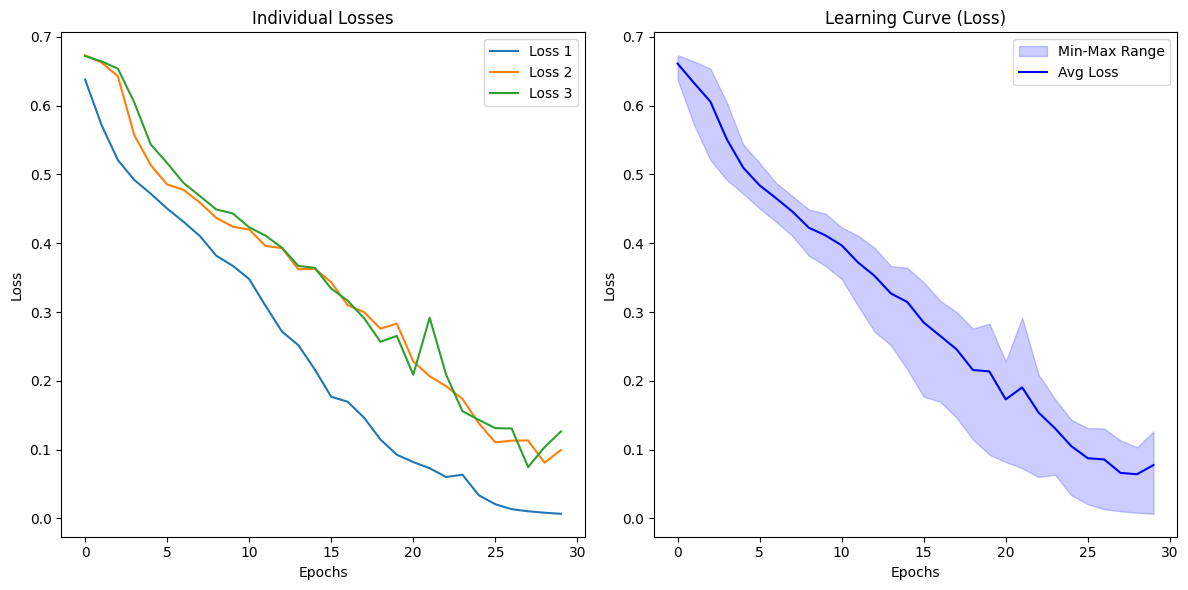



BASELINE MODEL:
Accuracy on test: 0.7308, f1-score on test: 0.7262



In [74]:
baseline_trainer = CustomTrainer(model=baseline_model, num_epochs=30, batch_size=64, learning_rate=0.001)

baseline_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)

baseline_accuracy, baseline_f1, baseline_probs, baseline_labels, baseline_error_df = baseline_trainer.test(test_df_embedded)
print('\n\nBASELINE MODEL:')
print(f"Accuracy on test: {baseline_accuracy:.4f}, f1-score on test: {baseline_f1:.4f}", end="\n\n")

### Train and evaluate Model 1.

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:08<00:00,  3.61it/s]


Accuracy on val: 0.7848, f1-score on val: 0.7756



Training with seed 1: 100%|██████████| 30/30 [00:08<00:00,  3.40it/s]


Accuracy on val: 0.7975, f1-score on val: 0.7850



Training with seed 2: 100%|██████████| 30/30 [00:08<00:00,  3.59it/s]


Accuracy on val: 0.7658, f1-score on val: 0.7489



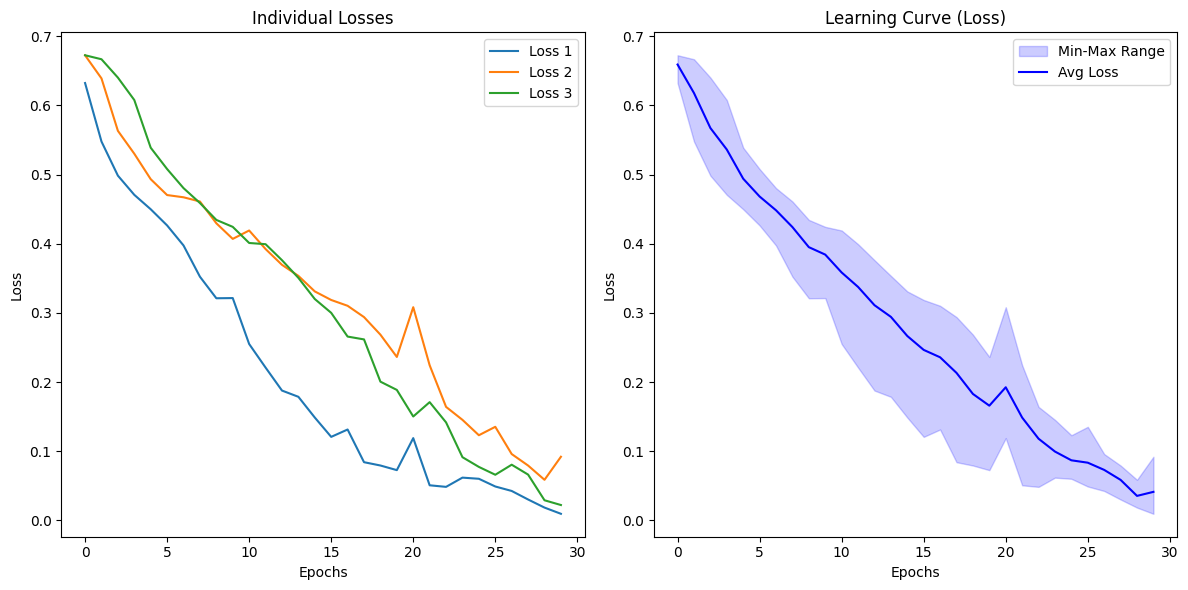



MODEL 1:
Accuracy on test: 0.7517, f1-score on test: 0.7415



In [75]:
model_1_trainer = CustomTrainer(model=model_1, num_epochs=30, batch_size=64, learning_rate=0.001)

model_1_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)
model_1_accuracy, model_1_f1, model_1_probs, model_1_labels, model_1_error_df = model_1_trainer.test(test_df_embedded)
print('\n\nMODEL 1:')
print(f"Accuracy on test: {model_1_accuracy:.4f}, f1-score on test: {model_1_f1:.4f}", end="\n\n")

Both models have good and stable training, with the learning curves showing losses going down smoothly and not much difference between the runs.

At the end of training, the losses are very low, so the models are learning well and not overfitting. The test set performs a little worse than validation, but this is normal, and the difference is not too big.

The second model, with one more LSTM layer, does a bit better than the first one, but the improvement is very small.

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [24]:
# Create copies of the original datasets to avoid modifying them directly
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

### Preprocess the tweets
Apply the same trasformation applied before for the LSTM model except for lemmatization and stopwords elimination.

In [25]:
def clean_tweet_transformer(tweet):
    """
    Cleans a tweet by removing unwanted characters, URLs, hashtags, mentions
    """
    # Remove non-ASCII characters
    tweet = re.sub(r'[^\x00-\x7F]+', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove non-alphanumeric characters (except spaces)
    tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)
    # Remove specific quote characters
    tweet = tweet.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')
    # Convert to lowercase
    cleaned_tweet = tweet.lower()

    return cleaned_tweet

In [26]:
train_df['tweet'] = train_df['tweet'].apply(clean_tweet_transformer)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet_transformer)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet_transformer)
train_df.head()

,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,writing a uni essay in my local pub with a cof...,1
200003,200003,en,it is 2021 not 1921 i dont appreciate that on...,1
200006,200006,en,according to a customer i have plenty of time ...,1
200007,200007,en,so only blokes drink beer sorry but if you are...,1
200008,200008,en,new to the shelves this week looking forward ...,0


### Define the model and the tokenizer
Use the Twitter-roBERTa-base for Hate Speech Detection model as requested.

In [27]:
# Define the task type (e.g., 'hate' for hate speech classification)
task = 'hate'

# Set the model name based on the task type
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

# Load the tokenizer for the specified model
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Load the pre-trained transformer model for sequence classification
transformer_model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Save the model to the local directory for future use
transformer_model.save_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

### Tokenize the tweets.

In [28]:
def preprocess_text(texts):
    # Use the tokenizer to process the 'tweet' column and apply truncation to handle long texts
    return tokenizer(texts['tweet'], truncation=True)

# Convert the training, validation, and test dataframes into HuggingFace Dataset objects
train_data = Dataset.from_pandas(train_df)
validation_data = Dataset.from_pandas(validation_df)
test_data = Dataset.from_pandas(test_df)

# Apply the preprocessing function to the dataset, using the 'batched' option to process in batches
train_data = train_data.map(preprocess_text, batched=True)
validation_data = validation_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

# Show the processed training data
train_data

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

Dataset({
    features: ['id_EXIST', 'lang', 'tweet', 'hard_label_task1', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 2870
})

In [29]:
# Rename the label columns to match with transformer default
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Define the traning arguments.

In [31]:
transformer_training_args = TrainingArguments(
    output_dir="test_dir",
    learning_rate=1e-6,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to='none'
)

In [32]:
def compute_metrics(output_info):
    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1)

    f1 = f1_score(y_pred=predictions, y_true=labels, average='macro')
    acc = accuracy_score(y_pred=predictions, y_true=labels)
    return {'f1': f1, 'acc': acc}

In [33]:
transformer_trainer = Trainer(
    model=transformer_model,
    args=transformer_training_args,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### Train the transformer model.

In [34]:
transformer_trainer.train()

Epoch,Training Loss,Validation Loss,F1,Acc
1,0.455200,0.429917,0.829289,0.835443
2,0.405600,0.482576,0.843176,0.848101
3,0.443400,0.508650,0.861767,0.867089
4,0.443800,0.519466,0.861767,0.867089


TrainOutput(global_step=2872, training_loss=0.441798914109764, metrics={'train_runtime': 382.1962, 'train_samples_per_second': 30.037, 'train_steps_per_second': 7.514, 'total_flos': 296000965057560.0, 'train_loss': 0.441798914109764, 'epoch': 4.0})

### Compute f1-score and accuracy on the test set.

In [35]:
# Use the trained transformer model to make predictions on the test data
transformer_test_prediction_info = transformer_trainer.predict(test_data)

# Extract the model predictions and the true labels from the prediction result
transformer_test_predictions, transformer_test_labels = transformer_test_prediction_info.predictions, transformer_test_prediction_info.label_ids

In [36]:
# Compute the evaluation metrics (such as F1 score and accuracy) for the test predictions
transformer_test_metrics = compute_metrics([transformer_test_predictions, transformer_test_labels])

# Extract the F1 score and accuracy from the computed metrics
transformer_f1 = transformer_test_metrics['f1']
transformer_accuracy = transformer_test_metrics['acc']

print(f"Accuracy on test: {transformer_accuracy:.4f}\nf1-score on test: {transformer_f1:.4f}", end="\n\n")

Accuracy on test: 0.8392
f1-score on test: 0.8378



The model shows steady training progress with decreasing training loss and stable F1 score and accuracy through epoch 3. However, the validation loss begins to rise after the first epoch, indicating potential overfitting.

The model achieves 0.8392 accuracy and 0.8378 F1-score on the test set, demonstrating strong performance on unseen data despite overfitting signals. These results suggest the model is learning effectively but could benefit from bigger dataset so that it would see more examples.

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



## Let’s begin by analyzing the dataset to explore its contents.

In [37]:
# Assign the DataFrames to variables for consistency
data_train = train_df
data_val = validation_df
data_test = test_df

# Rename the 'hard_label_task1' column to 'label' in the datasets for consistency
data_train = data_train.rename(columns={'hard_label_task1': 'label'})
data_val = data_val.rename(columns={'hard_label_task1': 'label'})
data_test = data_test.rename(columns={'hard_label_task1': 'label'})

<h3> Data and Label distribution <br>
<p> We start by looking at the data and label distribution to understand the dataset better. This helps us spot imbalances or patterns that might affect the model's performance.

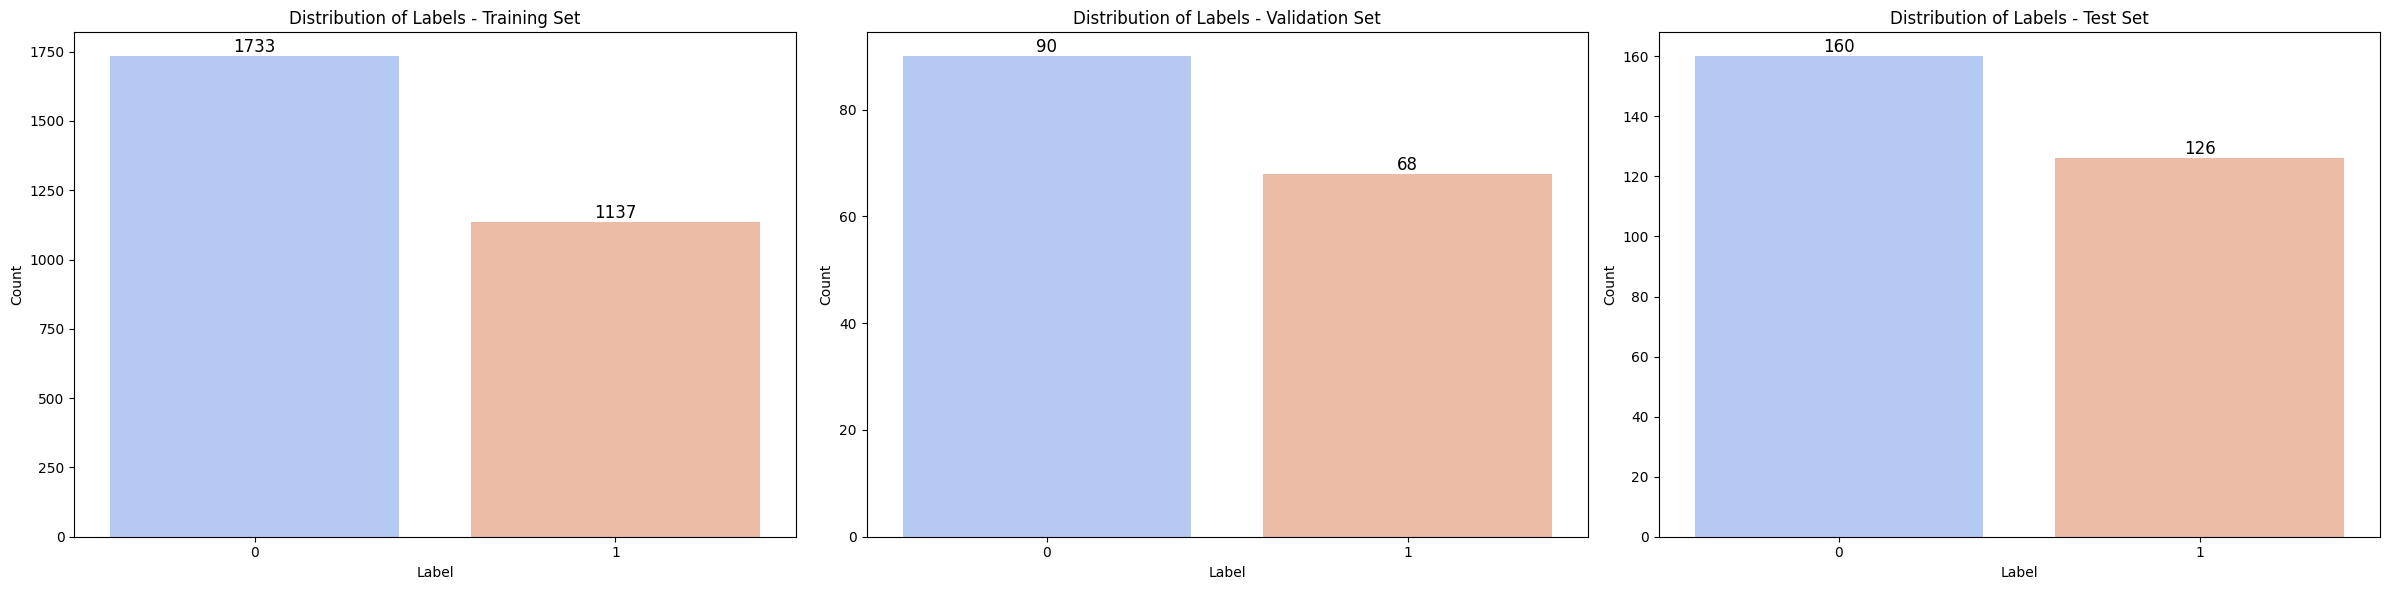

In [38]:
def plot_label_distribution(data_list, labels):
    n = len(data_list)  # Get the number of datasets
    plt.figure(figsize=(n * 8, 6))  # Adjust the figure size based on the number of datasets

    for i in range(n):
        data = data_list[i]

        # Create subplot
        ax = plt.subplot(1, n, i + 1)  # 1 row, n columns, position i+1
        sns.countplot(data=data, x='label', palette='coolwarm', ax=ax)
        plt.title(f'Distribution of Labels - {labels[i]}')
        plt.xlabel('Label')
        plt.ylabel('Count')

        # Annotate each bar with the exact count value
        for patch in ax.patches:
            height = patch.get_height()  # Get the height of the bar (count)
            ax.text(patch.get_x() + patch.get_width() / 2, height,
                    f'{int(height)}', ha='center', va='bottom', fontsize=12)  # Position the text

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


plot_label_distribution([data_train, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])

<p>The graph highlights a slight imbalance in label distribution across the training, validation, and test sets, where non-sexist tweets (Label 0) appear more frequently than sexist tweets (Label 1). This disparity could bias the model toward predicting non-sexist labels, potentially missing sexist content. Fixing this class imbalance is very important to get better results, especially for things like recall and precision, to correctly find sexist tweets.

<h3> Distribution of Tweet Lengths
<p> To gain deeper insights into the dataset, we aim to analyze the distribution of tweet lengths across the training, validation, and test sets. By plotting these distributions, we can identify any patterns or differences in tweet lengths among the splits. This analysis is intresting as such variations might impact the model's performance.


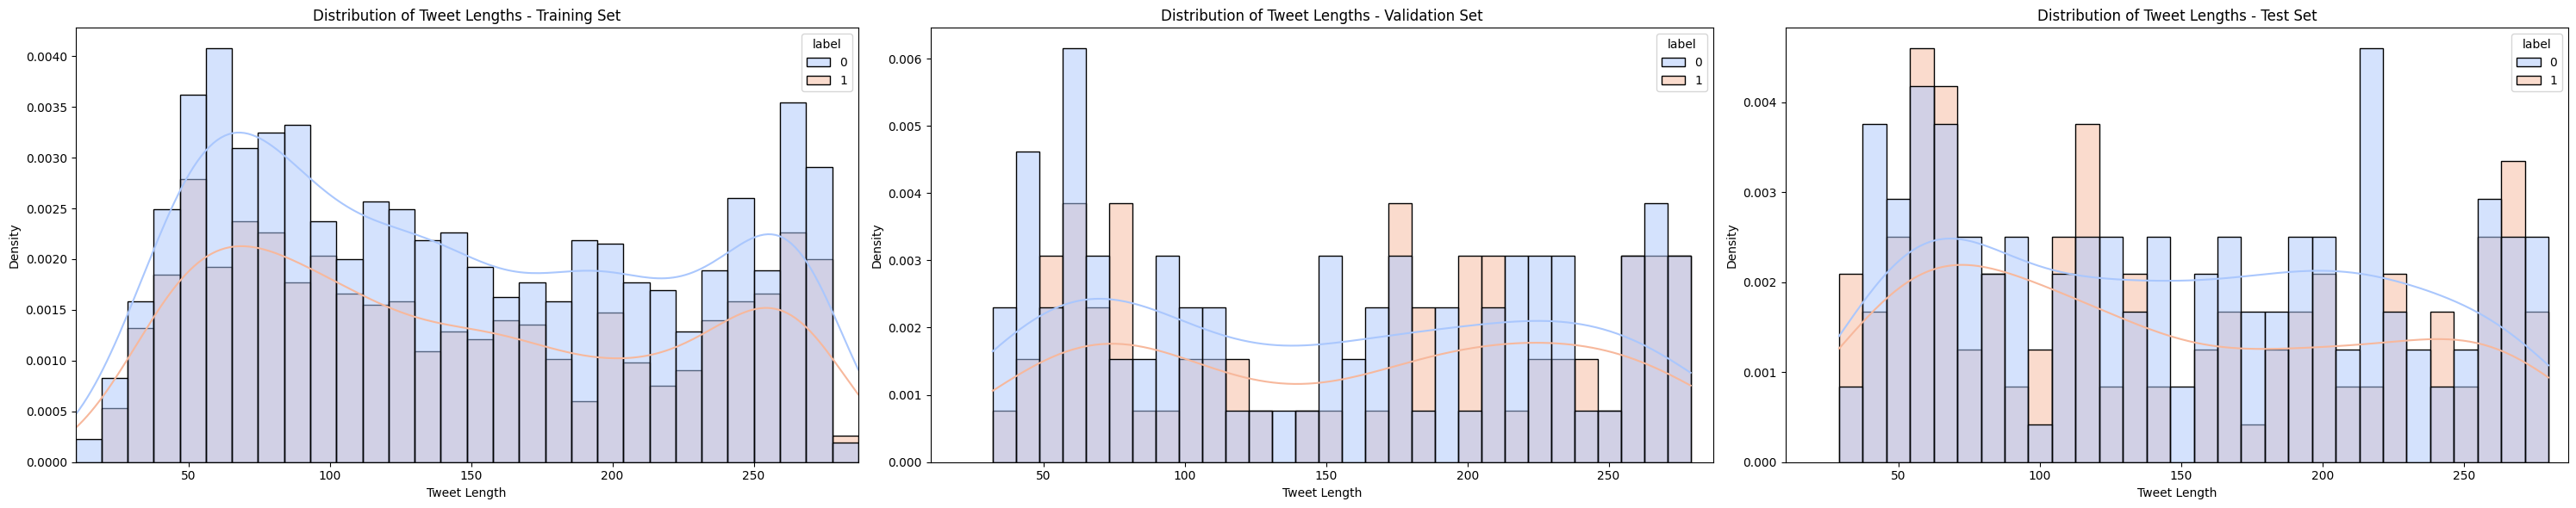

In [39]:
def plot_distr_tweet_len(data_list_or, labels):
    data_list = []
    for data_or in data_list_or:
        data = data_or.copy()
        data['tweet_length'] = data['tweet'].apply(len)
        data_list.append(data)

    # Determine global x and y axis limits
    all_lengths = pd.concat([data['tweet_length'] for data in data_list])
    x_min, x_max = all_lengths.min(), all_lengths.max()

    # Determine the number of datasets
    n = len(data_list)

    # Create a single figure with subplots arranged in 1 row and n columns
    plt.figure(figsize=(n * 10, 6))  # Adjust the figure size based on the number of datasets

    for i, data in enumerate(data_list):
        ax = plt.subplot(1, n, i + 1)  # 1 row, n columns, position i+1
        sns.histplot(data, x='tweet_length', hue='label', bins=30, kde=True, palette='coolwarm', ax=ax, stat='density')
        ax.set_title(f'Distribution of Tweet Lengths - {labels[i]}')
        ax.set_xlabel('Tweet Length')
        ax.set_ylabel('Density')  # Density instead of Frequency
        ax.set_xlim(x_min, x_max)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

plot_distr_tweet_len([data_train, data_val, data_test], labels=['Training Set', 'Validation Set', 'Test Set'])

By looking at the distribution curves we can see that they are pretty similar and have similar shape, in all the three plots the blue line is over the orange one, conferming that the number of tweets with label 0 is higher than the number of tweets with label 1 as shown before.

<h3> Most frequent words per label
<p> Let’s plot the most frequent words for each label to see which words are most common in different categories. This can give us insights into the key features associated with each label.

In [40]:
def analyze_top_words_by_label(data, text_column='tweet', label_column='label', n_top_words=20, excluded_words=set()):
    """
    Analyzes the most frequent words in a dataset, grouped by a specific label. This function preprocesses the text data,
    tokenizes the text, removes stopwords (including custom exclusions), and visualizes the top 'n' words for each label.
    """
    # Ensure the input data has the required columns
    if text_column not in data.columns or label_column not in data.columns:
        raise ValueError(f"Dataframe must contain '{text_column}' and '{label_column}' columns.")

    # Define stop words (including custom exclusions and punctuation)
    stop_words = set(stopwords.words('english') + list(string.punctuation) + list(excluded_words))

    # Preprocessing function to clean and tokenize the text
    def preprocess_text(text):
        tokens = word_tokenize(text.lower())  # Tokenize and convert to lower case
        filtered_words = [word for word in tokens if word not in stop_words and word.isalnum()]
        return ' '.join(filtered_words)

    # Apply preprocessing to the text column
    data['cleaned_text'] = data[text_column].apply(preprocess_text)

    # Function to extract top n words from a collection of texts
    def get_top_words(texts, n=20):
        all_words = ' '.join(texts).split()
        most_common = Counter(all_words).most_common(n)
        return pd.DataFrame(most_common, columns=['word', 'count'])

    # Initialize dictionary for storing top words by label and find max count for consistent axis scaling
    max_count = 0
    label_top_words = {}

    for label in data[label_column].unique():
        subset = data[data[label_column] == label]
        top_words = get_top_words(subset['cleaned_text'], n=n_top_words)
        # Exclude unwanted words
        top_words = top_words[~top_words['word'].isin(excluded_words)]

        # Store the top words for the label and update max count for consistent plotting
        label_top_words[label] = top_words
        if not top_words.empty:
            max_count = max(max_count, top_words['count'].max())

    # Determine the number of rows and columns for subplots
    num_labels = len(label_top_words)
    num_cols = 2
    num_rows = (num_labels + num_cols - 1) // num_cols  # This ensures enough rows to fit all plots

    # Create subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 8, num_rows * 8))
    axes = axes.flatten()  # Flatten to make indexing easier

    # Plot top words for each label
    for idx, (label, top_words) in enumerate(label_top_words.items()):
        if not top_words.empty:
            sns.barplot(data=top_words, x='count', y='word', palette='coolwarm', ax=axes[idx])
            axes[idx].set_title(f"Top Words for Label: {label}")
            axes[idx].set_xlabel('Count')
            axes[idx].set_ylabel('Word')
            axes[idx].set_xlim(0, max_count + 5)  # Adding a small margin for better visuals

    # Remove any unused axes
    for j in range(num_labels, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

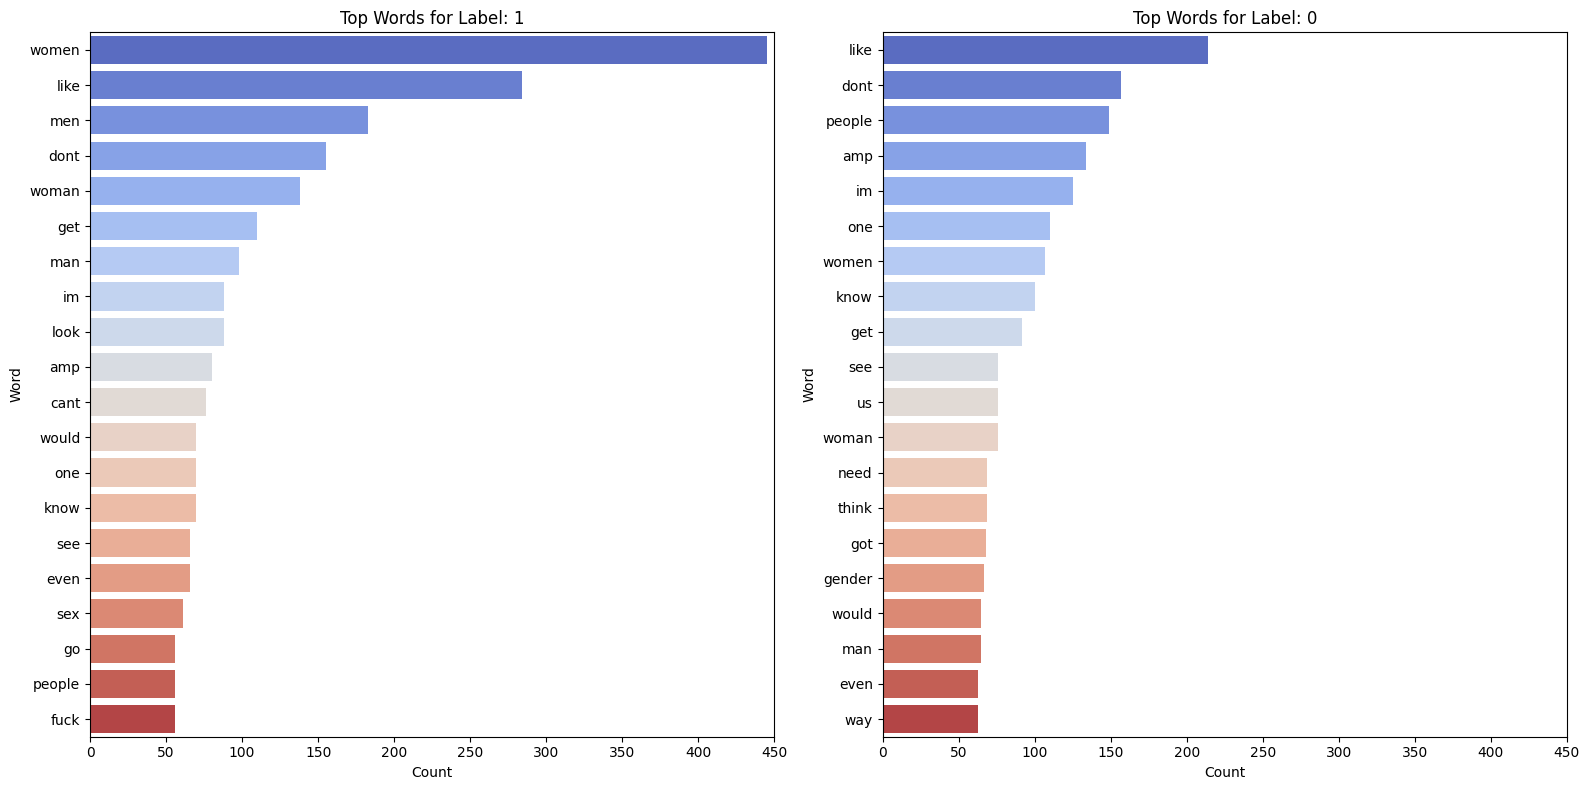

In [41]:
analyze_top_words_by_label(data_train, text_column='tweet', label_column='label', n_top_words=20)

<p> We can see that some of the most frequent words are common to the two labels and are useless to the analysis. <br> <br>
So, we eclude some of the common words between the two labels to have a better understanding of the situation and the word that are striclty related to a certain label, if any.

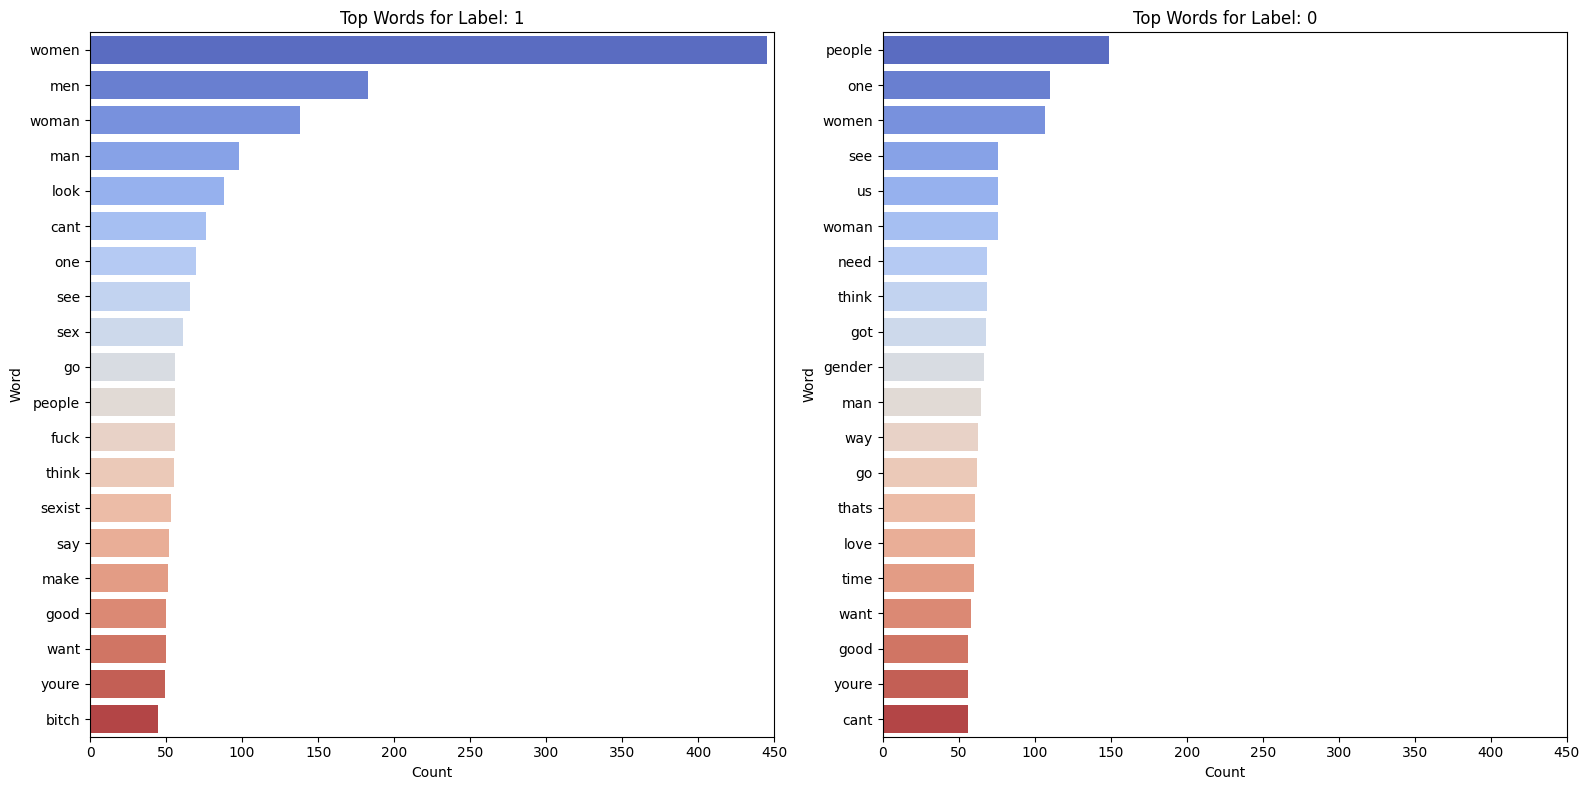

In [42]:
excluded_words = {'dont', 'get', 'amp', 'like', 'get', 'know', 'would', 'even', 'im'}
analyze_top_words_by_label(data_train, text_column='tweet', label_column='label', n_top_words=20, excluded_words=excluded_words)

The two plots share the same "Count-axis", therefore we can see that "women" appears a lot more in the sexist tweets toghter with woman, man and men all words that can be used in sentences that highlight some differences between the two genders. Additionally, the top 20 words associated with the sexist label often reflect an aggressive tone, making them key indicators for labeling.

## Analysis of the models

### Confusion matrix and Precision-Recall curve
<p> Plot the confusion matrix, the Precision-Recall curve and the classification report to have a better understanding of the results achieved by the trained models. <br>
The confusion matrix is usefull to see if there an equal number of false potives and false negatives. <br>
The Precision-Recall curve computes precision-recall pairs for different probability thresholds. <br>
The classification report shows accuracy, precision, recall, f1-score and support of the predictions, helping in the understanding of the obtained results.


In [57]:
def plot_confusion_and_pr_curve(y_test, y_prob):
    """
    Given binary labels (y_true) and binary predictions (y_pred),
    this function will plot the confusion matrix, precision-recall curve,
    and classification report side by side.
    """
    #y_pred = np.argmax(y_prob, axis=-1)

    if y_prob.ndim == 2 and y_prob.shape[1] == 2:  # if y_prob is in shape (x, 2), probabilities for both classes
        y_pred = np.argmax(y_prob, axis=-1)  # Get predicted class
        y_prob_pos = y_prob[:, 1]  # Probabilities of the positive class
    elif y_prob.ndim == 1:  # if y_prob is in shape (x,), it represents predicted class labels directly
        y_pred = (y_prob >= 0.5).astype(int)  # Threshold at 0.5 to get predicted class (0 or 1)
        y_prob_pos = y_prob  # These are the probabilities for the positive class

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Precision-Recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob_pos)

    # Create a figure with three subplots in one row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"],
                yticklabels=["Negative", "Positive"], ax=ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted")
    ax1.set_ylabel("Actual")

    # Precision-Recall Curve
    ax2.plot(recall, precision, color="b", label="Precision-Recall Curve")
    ax2.fill_between(recall, precision, color="skyblue", alpha=0.4)
    ax2.set_title("Precision-Recall Curve")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    ax2.legend(loc="lower left")

    # Create a styled table with nicer formatting
    report = classification_report(y_test, y_pred, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Round numeric values to 2 decimal places
    report_df.iloc[:, :-1] = report_df.iloc[:, :-1].round(2)
    report_df.loc["accuracy", ["precision", "recall"]] = None
    report_df.loc["accuracy", "support"] = 286

    ax3.axis("off")
    table_data = report_df.reset_index()
    table = ax3.table(cellText=table_data.values, colLabels=table_data.columns,
                      cellLoc="center", loc="center", bbox=[0, 0, 1, 1])

    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(table_data.columns))))

    # Apply styles to headers and rows
    for (row, col), cell in table.get_celld().items():
        cell.set_edgecolor("black")
        if row == 0:  # Header row
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#f4f4f4")
        elif col == 0:  # First column (index)
            cell.set_text_props(weight="bold")
            cell.set_facecolor("#f4f4f4")  # Light grey for readability
        else:  # All other cells
            value = table_data.values[row - 1, col] if row > 0 else table_data.columns[col]  # Adjust index for header
            if pd.isna(value):
                cell.get_text().set_text("")
            cell.set_facecolor("white")
            cell.set_alpha(0.9)

    ax3.set_title("Classification Report", fontsize=14)

    plt.tight_layout()
    plt.show()

**Baseline model**

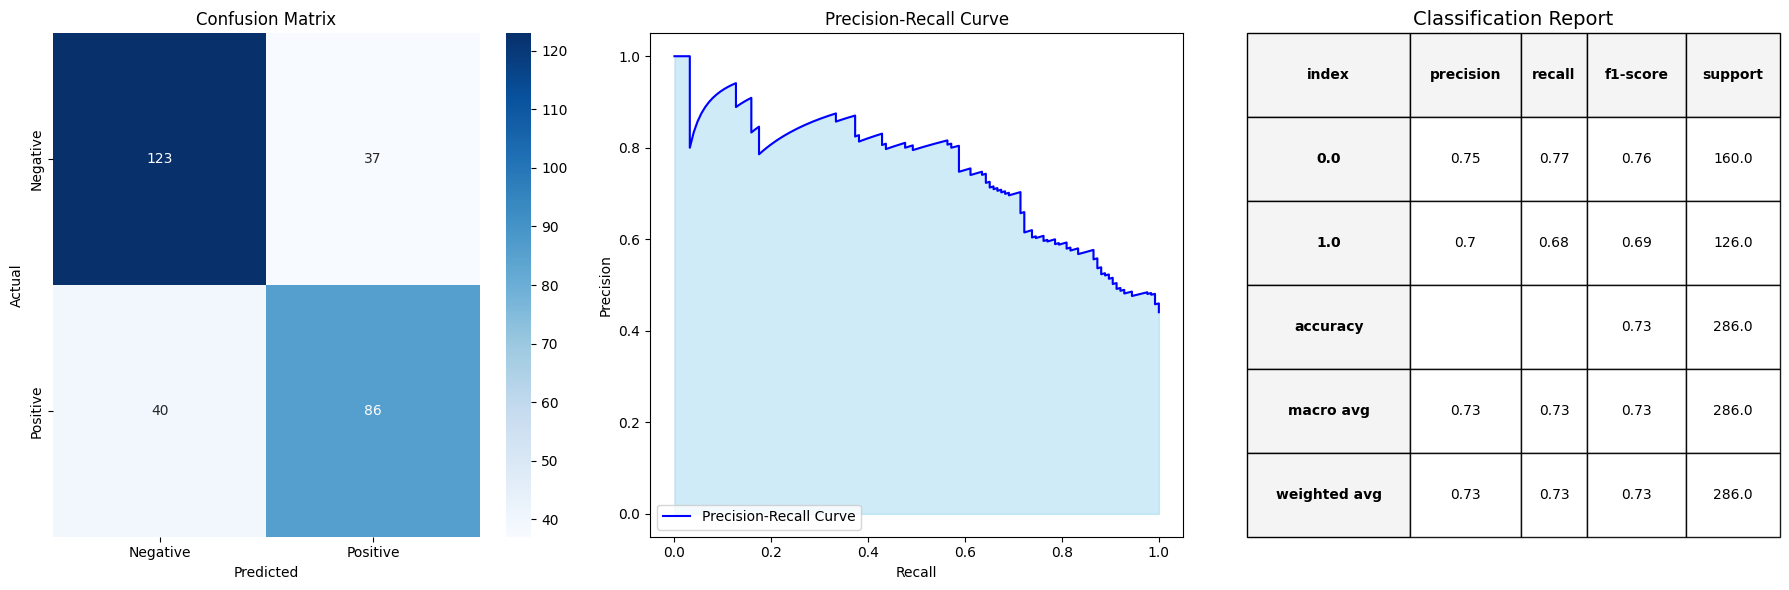

In [76]:
plot_confusion_and_pr_curve(baseline_labels, baseline_probs)

**Model 1**

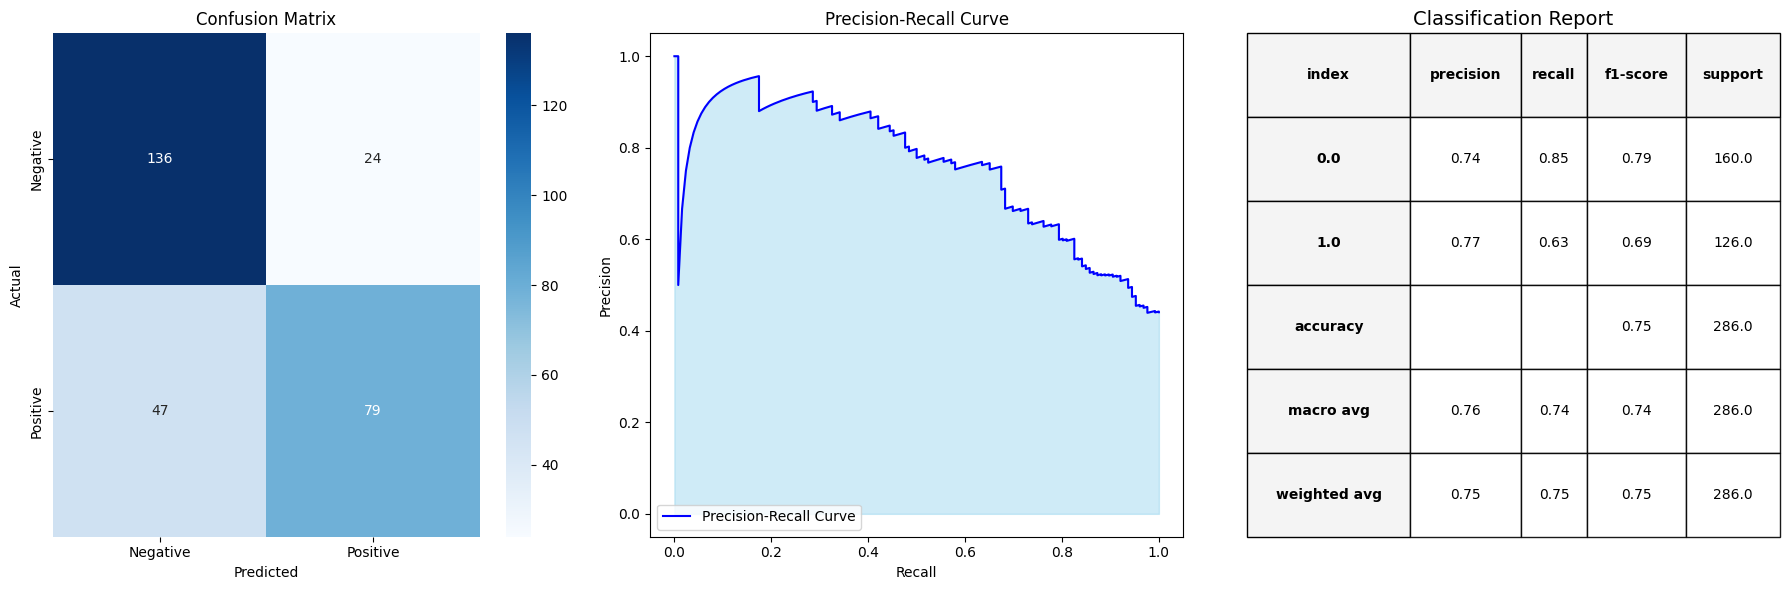

In [77]:
plot_confusion_and_pr_curve(model_1_labels, model_1_probs)

**Transformer model**

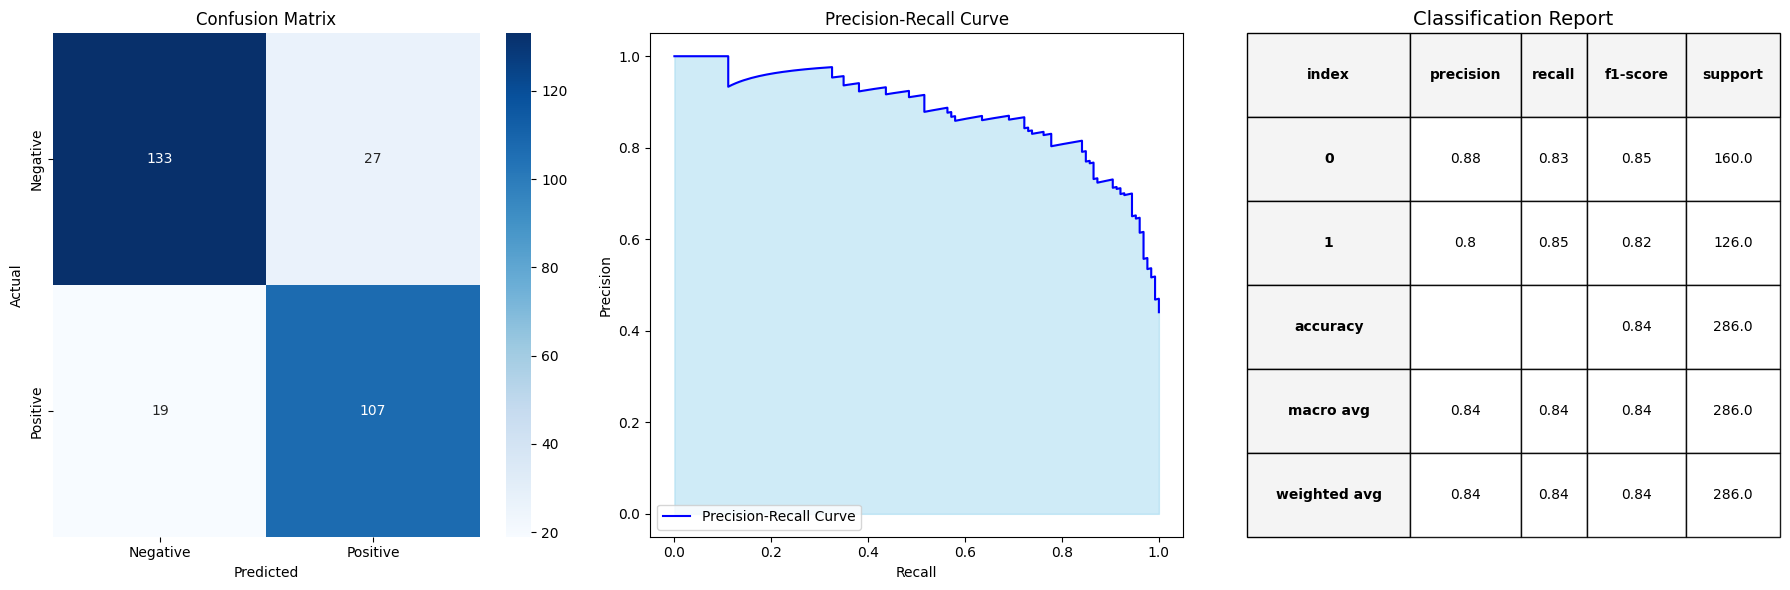

In [60]:
plot_confusion_and_pr_curve(transformer_test_labels, transformer_test_predictions)

The three plots illustrate key differences in the performance of the baseline, Model 1, and the transformer model in handling false positives and false negatives. Both the baseline and Model 1 demonstrate a tendency to produce slightly more false negatives than false positives. This behavior reflects the imbalance already observed in the dataset during both training and testing phases, where the models may struggle to correctly identify the minority class, leading to a bias toward underpredicting certain categories.

In contrast, the transformer model exhibits a different pattern. It generates more false positives than false negatives, indicating a more balanced recall between the two classes (0-predictions and 1-predictions). This suggests that the transformer model is better at capturing the nuanced structure of the input text, enabling it to make more informed predictions for both classes. This capability comes from the transformer's ability to model complex relationships in the data through its attention mechanisms and deeper contextual understanding. As a result, the transformer model achieves superior overall performance, as reflected in its higher accuracy and F1-score compared to the baseline and Model 1.

The Precision-Recall (PR) curves further underline those differences. The PR curve for the transformer model demonstrates a higher area under the curve (AUC) than those of the baseline and Model 1. This higher AUC indicates that the transformer model consistently balances precision and recall across different thresholds, reinforcing its superior ability to generalize across the dataset and capture both majority and minority class patterns more effectively.

### Misclassified samples
We can also have a look into specific misclassified samples to understand if there is some pattern or common aspect in the misclassified tweets, here we consider only the output from the transformer model since we will analyze the errors from the other two later.

In [47]:
def analyze_errors(text, pred, label, tokenizer):
    # Check if pred and label are of the same length
    if len(pred) != len(label):
        raise ValueError("The length of prediction and label lists must be the same.")

    # Initialize a list to store the results of incorrect predictions
    incorrect_preds = []
    output_list = []

    if len(pred.shape)>1:
        pred = np.argmax(pred, axis=-1)
    # Iterate through each token in the prediction and label
    for i in range(len(pred)):
        # If the prediction is incorrect, we'll process this token
        if pred[i] != label[i]:
            incorrect_preds.append((text[i], i))
            output_list.append((text[i], pred[i]))

    print(f"Number of incorrect prediction: {len(incorrect_preds)}")
    print("First dot reprsent label, red means sexist")
    print("-----------------------------------------------------------------------------------")
    # If there are incorrect predictions, print them and color OOV tokens
    for err, idx in incorrect_preds:
        if label[idx] == 1:
            print("🔴", end=" ")
        else:
            print("🟢", end=" ")
        print(err)

    return output_list

incpreds = analyze_errors(data_test['tweet'], transformer_test_predictions, transformer_test_labels, tokenizer)

Number of incorrect prediction: 46
First dot reprsent label, red means sexist
-----------------------------------------------------------------------------------
🔴 suika gets gangbanged to death 
🟢   sex as in gender harassment is what they are inferring
🟢 isa hot girl summer now pop yall shit 
🟢  how did we reach a point where blonks are having the audacity to talk about yoongis rap do yall see who you stan  are yall ok  your girls cant write cant deliver cant come close to btss lyricism tf are yall getting brave for  fashion deals 
🔴    that gold digger is nice but the picture and set up for them are elite pinwork is like the revealing of the mona lisa always a work of art
🟢  well let me ask for the guys do you ever just grab your testicles because you can
🔴 dear  fans can we not harass talented actors of color stop being racist douche nozzles this is why we cant have nice things moses is a badass inquisitor and yall cant handle her badassary 
🟢 some one get those white boy hips movi

The false positives (labeled as sexist when they are not) include statements that reference societal issues, sexual harassment statistics, or gender-related observations

The false negatives (statements predicted as non-sexist when they are sexist) often reference direct acts of misogyny, objectification, or discriminatory generalizations

Statements that include sarcasm, ambiguity, or multiple layers of meaning (e.g., statements about “phallocentrism” or “manspreading”) are misclassified. This suggests a gap in the model's ability to parse deeper linguistic context or tone.

Sarcasm, slang, and indirect references (e.g., phrases like "testicles," "manspreading," and "gender harassment") lead to confusion in classification.

Some misclassifications comes from associating certain words or concepts with sexist labels without fully analyzing their meaning in context.
For instance:

    Statements like “dear fans can we not harass talented actors of color...” should likely be flagged as anti-harassment, not sexist.
    The term “manspreading” is used in sociopolitical critique here, but the model might see the term itself and classify it as sexist.

The model shows weaknesses in context understanding.

### OOV token per tweet analysis
We can also plot the specific OOV token insied each miscassified tweets to have a better understanding of what is happening inside the model.

In [48]:
test_df = original_test_df.copy()
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)

In [61]:
def compute_average_oov(df, column_name, vocabulary):
    """
    Computes the average number of out-of-vocabulary (OOV) tokens per tweet.
    """
    vocabulary = set(vocabulary.keys())
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' not found in the DataFrame.")

    if not isinstance(vocabulary, set):
        raise ValueError("Vocabulary must be a set of words.")

    def count_oov_tokens(tweet):
        tokens = tweet.split()  # Simple tokenization by splitting on spaces
        return sum(1 for token in tokens if token.lower() not in vocabulary)

    oov_counts = df[column_name].apply(count_oov_tokens)
    average_oov = oov_counts.mean()

    print(f"Average OOV tokens per tweet: {average_oov:.2f}")

compute_average_oov(test_df, 'tweet', vocab)

Average OOV tokens per tweet: 2.48


In [50]:
def highlight_oov_tokens(df, vocabulary, tweet_column="tweet", label_column="label", oov_column="oov_token_count"):
    # Extract vocabulary keys
    vocab_keys = set(vocabulary.keys())

    def count_oov_tokens(tweet):
        """Count OOV tokens in a tweet."""
        tokens = tweet.split()  # Assuming tweets are space-separated strings
        return sum(1 for token in tokens if token not in vocab_keys)

    def highlight_tokens(tweet):
        """Highlight OOV tokens in red within the tweet."""
        tokens = tweet.split()  # Assuming tweets are space-separated strings
        highlighted = [
            f"\033[91m{token}\033[0m" if token not in vocab_keys else token
            for token in tokens
        ]
        return " ".join(highlighted)

    # Add OOV token counts to the DataFrame
    df[oov_column] = df[tweet_column].apply(count_oov_tokens)

    # Calculate and print the average OOV token count per tweet
    average_oov = df[oov_column].mean()
    print(f"Average OOV tokens per tweet: {average_oov:.2f}\n")

    # Print the tweets with OOV tokens highlighted
    print(f"\n{'Label':<6}{'Tweet (OOV tokens highlighted in red)':<60}")
    print("-" * 70)

    for _, row in df.iterrows():
        label = row[label_column]
        tweet = row[tweet_column]
        label_emoji = "🔴" if label == 1 else "🟢"
        highlighted_tweet = highlight_tokens(tweet)
        print(f"{label_emoji:<6}{highlighted_tweet}")

In [51]:
highlight_oov_tokens(baseline_error_df, vocab, tweet_column="tweet", label_column="label", oov_column="oov_token_count")

Average OOV tokens per tweet: 2.23


Label Tweet (OOV tokens highlighted in red)                       
----------------------------------------------------------------------
🔴     suika get gangbanged death
🔴     maybe something involving getting gangbanged
🟢     sex gender harassment inferring
🔴     kabul islamic emirate afghanistan announced end coeducation country citing gender harassmentfemale student attend university monday wednesday saturday tuesday thursday sunday fixed male
🟢     appreciate included along uvalde gunman history cyber gender harassment regrettably unshocking
🔴     violent antifeminism farright movement see principally vessel breeding new white generation express fixation areturn traditional gender rolesworth every minute read take 5 min sun
🔴     ah look gender role back dont believe lie
🟢     baby called mommy sha first time today twice yall dont understand hype made baby girl autism getting talk without prompted challenge shes come far
🟢     reach point blonk

In [52]:
highlight_oov_tokens(model_1_error_df, vocab, tweet_column="tweet", label_column="label", oov_column="oov_token_count")

Average OOV tokens per tweet: 1.82


Label Tweet (OOV tokens highlighted in red)                       
----------------------------------------------------------------------
🔴     suika get gangbanged death
🔴     maybe something involving getting gangbanged
🟢     sex gender harassment inferring
🔴     kabul islamic emirate afghanistan announced end coeducation country citing gender harassmentfemale student attend university monday wednesday saturday tuesday thursday sunday fixed male
🔴     violent antifeminism farright movement see principally vessel breeding new white generation express fixation areturn traditional gender rolesworth every minute read take 5 min sun
🔴     ah look gender role back dont believe lie
🟢     baby called mommy sha first time today twice yall dont understand hype made baby girl autism getting talk without prompted challenge shes come far
🟢     reach point blonks audacity talk yoongis rap yall see stan yall ok girl cant write cant deliver cant come close btss l

Lemmatization can complicate tone understanding, this issue applies to both models, as they often struggle with context. Additionally, some slang terms, such as 'gold digger,' are not accurately identified by the model as insulting. This is because the model interprets the phrase by breaking it into its individual words—'gold' and 'digger'—which are not inherently harmful on their own.

As we can see, the number of OOV tokens in the misclassified examples is lower than the average number of OOV tokens in the test set. This suggests that the presence of OOV tokens alone does not significantly affect classification accuracy, and other factors are likely impacting the model's performance.

## Change Glove embedding dimension
Change the embedding dimension to 200 to see if it improves the performances of baseline and model 1. Doubling the dimension of the embeddings from 100 to 200 should produce embeddings that capture more features between words. If the dataset has certain features to learn, the models should improve; if not, it should perform worse due to excessively high dimensionalities.

In [78]:
train_df = original_train_df.copy()
validation_df = original_validation_df.copy()
test_df = original_test_df.copy()

train_df['tweet'] = train_df['tweet'].apply(clean_tweet)
validation_df['tweet'] = validation_df['tweet'].apply(clean_tweet)
test_df['tweet'] = test_df['tweet'].apply(clean_tweet)


# Define the embedding dimension
embedding_dim = 200
# Path to the specific GloVe file for the desired dimension
glove_filepath = os.path.join(extract_path, f'glove.6B.{embedding_dim}d.txt')
# Load the embeddings into memory
glove_embeddings = load_glove_embeddings(glove_filepath, embedding_dim)
print("Loaded GloVe embeddings with dimension:", embedding_dim)


# Find the maximum length of tweets across train, validation, and test datasets
MAX_LEN = find_series_max_len([train_df['tweet'], validation_df['tweet'], test_df['tweet']])
print(f"Maximum length found: {MAX_LEN}")

# Pad the 'tweet' column in train, validation, and test DataFrames
train_df = pad_text_column(train_df, 'tweet', MAX_LEN)
validation_df = pad_text_column(validation_df, 'tweet', MAX_LEN)
test_df = pad_text_column(test_df, 'tweet', MAX_LEN)
# Print the first padded tweet from the training DataFrame
print(train_df['padded_tweet'].iloc[0])


# Build vocabulary and embeddings for the training set
vocab, word_embeddings = build_vocab_and_embeddings(train_df, glove_embeddings, embedding_dim)

# Special handling for the '[UNK]' token (unknown token)
unk_token = '[UNK]'
vocab[unk_token] = len(vocab)

# Compute the embedding for the unknown token as the mean of all word embeddings
unk_embedding = np.mean(word_embeddings, axis=0)
word_embeddings = np.vstack([word_embeddings, unk_embedding])

# Embed all the df with our extended GloVe embeddings
train_df_embedded = embed_tweet(train_df, vocab, word_embeddings)
validation_df_embedded = embed_tweet(validation_df, vocab, word_embeddings)
test_df_embedded = embed_tweet(test_df, vocab, word_embeddings)

Loading GloVe embeddings from glove/glove.6B.200d.txt...
GloVe embeddings loaded.
Loaded GloVe embeddings with dimension: 200
Maximum length found: 36
['writing', 'uni', 'essay', 'local', 'pub', 'coffee', 'random', 'old', 'man', 'keep', 'asking', 'drunk', 'question', 'im', 'trying', 'concentrate', 'amp', 'end', 'good', 'luck', 'youll', 'end', 'getting', 'married', 'use', 'anyway', 'alive', 'well', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']


Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:11<00:00,  2.64it/s]


Accuracy on val: 0.7722, f1-score on val: 0.7565



Training with seed 1: 100%|██████████| 30/30 [00:12<00:00,  2.39it/s]


Accuracy on val: 0.8165, f1-score on val: 0.8032



Training with seed 2: 100%|██████████| 30/30 [00:10<00:00,  2.93it/s]


Accuracy on val: 0.7405, f1-score on val: 0.7237



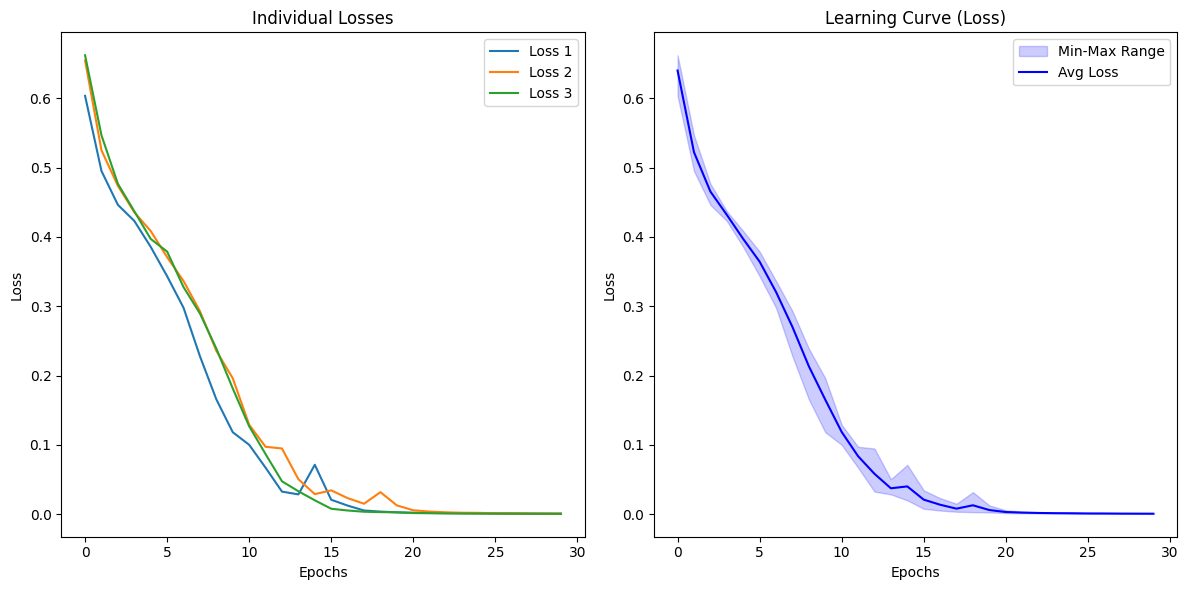



BASELINE MODEL:
Accuracy on test: 0.7413, f1-score on test: 0.7350



In [79]:
input_size = embedding_dim
hidden_size = 128
num_layers = 1
output_size = 1

baseline_model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
baseline_trainer = CustomTrainer(model=baseline_model, num_epochs=30, batch_size=32, learning_rate=0.001)

baseline_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)

baseline_accuracy, baseline_f1, baseline_probs, baseline_labels, baseline_error_df = baseline_trainer.test(test_df_embedded)
print('\n\nBASELINE MODEL:')
print(f"Accuracy on test: {baseline_accuracy:.4f}, f1-score on test: {baseline_f1:.4f}", end="\n\n")

Using device: cuda

### Start training and testing with 3 seeds ###


Training with seed 0: 100%|██████████| 30/30 [00:18<00:00,  1.60it/s]


Accuracy on val: 0.7785, f1-score on val: 0.7656



Training with seed 1: 100%|██████████| 30/30 [00:21<00:00,  1.39it/s]


Accuracy on val: 0.7911, f1-score on val: 0.7804



Training with seed 2: 100%|██████████| 30/30 [00:20<00:00,  1.46it/s]


Accuracy on val: 0.7595, f1-score on val: 0.7430



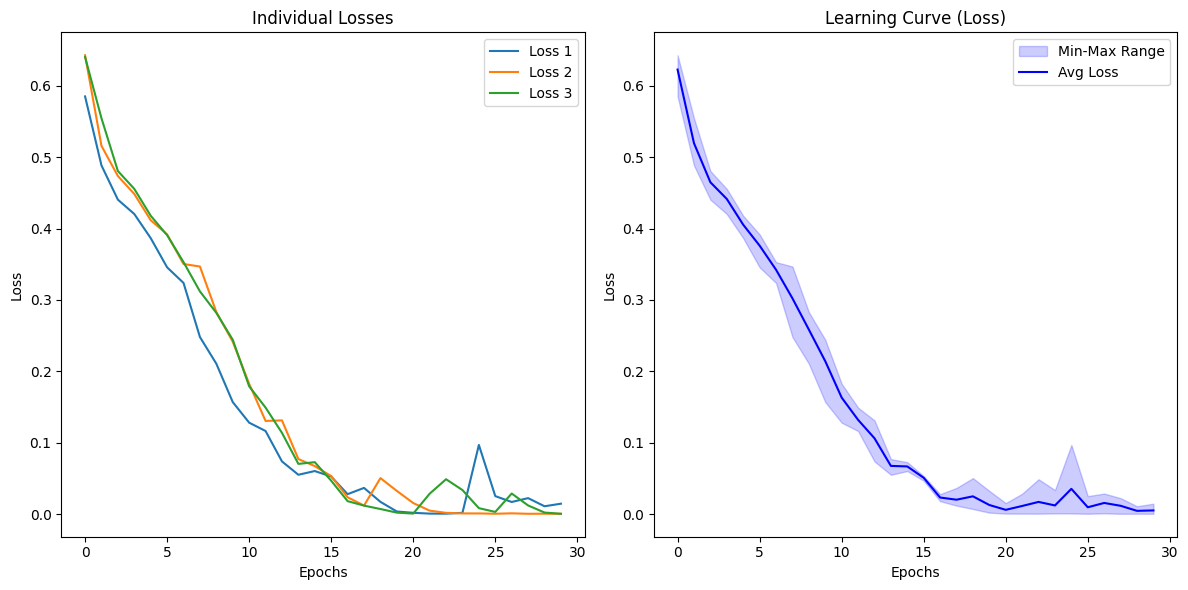



MODEL 1:
Accuracy on test: 0.7587, f1-score on test: 0.7514



In [80]:
num_layers = 2

model_1 = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
model_1_trainer = CustomTrainer(model=model_1, num_epochs=30, batch_size=32, learning_rate=0.001)

model_1_trainer.train_and_evaluate_multiple_seeds(train_df_embedded, validation_df_embedded, num_seeds=3)
model_1_accuracy, model_1_f1, model_1_probs, model_1_labels, model_1_error_df = model_1_trainer.test(test_df_embedded)
print('\n\nMODEL 1:')
print(f"Accuracy on test: {model_1_accuracy:.4f}, f1-score on test: {model_1_f1:.4f}", end="\n\n")

As the results show, the performances of the two models are very similar when changing the GloVe embedding dimension from 100 to 200.

GloVe embeddings of dimension 200 might capture more nuanced and detailed relationships between words, but this additional detail may not be meaningful for the sexist classification task. In contrast, 100-dimensional embeddings may offer a simpler, more general representation that aligns better with the task of binary classification.

Also, higher-dimensional embeddings require the model to learn from more parameters. The 200-dimensional embeddings model might struggle to effectively learn meaningful patterns in such a high-dimensional space, leading to simlar performance. Instead, 100-dimensional embeddings require fewer parameters and are easier for the model to generalize.

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End